In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

from dotenv import load_dotenv
load_dotenv()

# GCP variables:
#PROJECT_ID=os.getenv('PROJECT_ID')
#BUCKET_NAME=os.getenv('BUCKET_NAME')
#USER=os.getenv('USER')
#LOCATION=os.getenv('LOCATION')
#SERVICE_ACCOUNT=os.getenv('SERVICE_ACCOUNT')

In [ ]:
#data_gcs_uri = f'gs://{BUCKET_NAME}/midterm_project/data/citi_bike_data_00000.csv'

# Data Cleaning & Preparation

We will use the data Kaggle data [Citi Bike Stations](https://www.kaggle.com/datasets/rosenthal/citi-bike-stations/) (only the `citi_bike_data_00000.csv`, a subset of stations). The dataset contains information on the New York City bike share system. It specifically contains the data reported by stations: how many bikes are available and how many docks are available at a specific point in time.

## OBJECTIVE

> Obtain a model that can **predict** the **number of bikes/docks available** at a specific station at a specific point in time.

Why? I want to be able to see what is going to be the **[1] bike availability** of the place I'll leave from at a specific time (to prevent). And also the **[2] dock availability** at the time I would arrive at a place.

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import math

# Load the Manhattan shapefile
manhattan = gpd.read_file('../images/manhattan_map/geo_export_f21dfb5a-3953-4e56-877a-4a3abd9673f4.shp')

In [ ]:
# Read data:
def read_csv(
    data_path: str,
) -> pd.DataFrame:
    """
    Funtion that:
    1. Reads the data from a path (either local or Google Cloud Storage).
    2. Perform recommended preprocessing: https://www.kaggle.com/datasets/rosenthal/citi-bike-stations/
    3. Additionally, filter the rows to avoid COVID as the behavior was different to what we may see know a days.
    4. Finally, remove rows with missing station information (name, lat, lon, etc). We remove it as
    there is no known reason why this data is missing and we've checked.
    """

    # 1. Read data:
    df = pd.read_csv(
        data_gcs_uri,
        sep=",",
        na_values="\\N",
        dtype={
            "station_id": str,
            # Use Pandas Int16 dtype to allow for nullable integers
            "num_bikes_available": "Int16",
            "num_ebikes_available": "Int16",
            "num_bikes_disabled": "Int16",
            "num_docks_available": "Int16",
            "num_docks_disabled": "Int16",
            "is_installed": "Int16",
            "is_renting": "Int16",
            "is_returning": "Int16",
            "station_status_last_reported": "Int64",
            "station_name": str,
            "lat": float,
            "lon": float,
            "region_id": str,
            "capacity": "Int16",
            # Use pandas boolean dtype to allow for nullable booleans
            "has_kiosk": "boolean",
            "station_information_last_updated": "Int64",
            "missing_station_information": "boolean"
        },
    )
    # 2. Preprocess:
    # Read in timestamps as UNIX/POSIX epochs but then convert to the local
    # bike share timezone.
    df["station_status_last_reported"] = pd.to_datetime(
        df["station_status_last_reported"], unit="s", origin="unix", utc=True
    ).dt.tz_convert("US/Eastern")

    df["station_information_last_updated"] = pd.to_datetime(
        df["station_information_last_updated"], unit="s", origin="unix", utc=True
    ).dt.tz_convert("US/Eastern")

    # 3. Filter only POST Covid dates:
    # Define the start and end date:
    start_date = pd.to_datetime("2020-12-01", utc=True).tz_convert("US/Eastern")
    end_date = pd.to_datetime("2021-12-01", utc=True).tz_convert("US/Eastern")
    # Filter the DataFrame for dates within the specified range
    df = df[(df["station_status_last_reported"] >= start_date)&(df["station_status_last_reported"] <= end_date)]

    # 4. Drop rows without station information:
    df = df.dropna()

    # --------------------------------------------
    # (Next you will see the rows that would need to be added to finish the preprocessing, you will need to read the
    # rest of the notebook to understand. We keep track of these steps to facilitate the job of future project deployment)
    # 5. Select only the region of interest:
    # df_nyc = df.query("region_id == '71'")
    # station_variables = ['station_id', 'station_name', 'lat', 'lon', 'region_id', 'capacity']
    # stations = df_nyc.groupby(station_variables).size().reset_index(name='count').copy()
    # stations = stations.sort_values(by='count', ascending=False).set_index('station_id')
    # 6. Obtain True Capacity:
    # df_prep.loc[df_prep["station_id"] == "3726", "capacity"] = 23
    # df_prep['true_bike_capacity'] = df_prep['capacity']-(df_prep['num_bikes_disabled']+df_prep['num_docks_disabled'])
    # df_prep['percentage_bikes_available'] = df_prep['num_bikes_available']*1.0/df_prep['true_bike_capacity'] 
    # df_prep['percentage_docks_available'] = df_prep['num_docks_available']*1.0/df_prep['true_bike_capacity']
    # df_prep['sum_percentage_validation'] = df_prep['percentage_bikes_available'] + df_prep['percentage_docks_available'] # Needs to be 1
    # 7. Removed capture errors:
    # df_prep = df_prep[df_prep['sum_percentage_validation'] == 1]
    # 8. Export data:
    # df_ml = df_prep[['station_id', 'station_status_last_reported', 'lat', 'lon', 'true_bike_capacity', 'percentage_bikes_available']].copy()
    # stations = df_prep.groupby(station_variables).size().reset_index(name='count')
    # return df_ml, stations
    # --------------------------------------------

    return df

In [ ]:
df = read_csv('../data/citi_bike_data_00000.csv')

In [ ]:
df.head()

,station_id,num_bikes_available,num_ebikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,station_status_last_reported,station_name,lat,lon,region_id,capacity,has_kiosk,station_information_last_updated,missing_station_information
3,3483,7,0,3,4,0,1,1,1,2021-11-19 13:24:46-05:00,Montgomery St,40.719420,-74.050990,70,14,True,2019-08-01 16:47:30-04:00,False
4,3483,4,0,1,9,0,1,1,1,2021-09-21 15:12:20-04:00,Montgomery St,40.719420,-74.050990,70,14,True,2019-08-01 16:47:30-04:00,False
5,3483,11,0,0,3,0,1,1,1,2021-06-14 16:25:16-04:00,Montgomery St,40.719420,-74.050990,70,14,True,2019-08-01 16:47:30-04:00,False
7,3483,12,0,0,2,0,1,1,1,2020-12-14 17:19:14-05:00,Montgomery St,40.719420,-74.050990,70,14,True,2019-08-01 16:47:30-04:00,False
14,385,3,0,2,24,0,1,1,1,2021-08-25 12:09:38-04:00,E 55 St & 2 Ave,40.757973,-73.966033,71,29,True,2019-08-01 16:47:30-04:00,False


In [ ]:
print(f'Number of rows: {df.size:,} million')

Number of rows: 9,288,234 million


## STATIONS

Let's get the specific station that we have data of:

In [ ]:
station_variables = ['station_id', 'station_name', 'lat', 'lon', 'region_id', 'capacity']
stations = df.groupby(station_variables).size().reset_index(name='count').copy()
stations = stations.sort_values(by='count', ascending=False).set_index('station_id')
stations

,station_name,lat,lon,region_id,capacity,count
station_id,,,,,,
466,W 25 St & 6 Ave,40.743954,-73.991449,71,35,81924
303,Mercer St & Spring St,40.723627,-73.999496,71,67,67207
259,South St & Whitehall St,40.701221,-74.012342,71,39,48657
385,E 55 St & 2 Ave,40.757973,-73.966033,71,29,45922
3113,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,71,27,42447
3690,Park Pl & Church St,40.713342,-74.009355,71,36,40255
3357,W 106 St & Amsterdam Ave,40.800836,-73.966449,71,35,38183
3195,Sip Ave,40.730897,-74.063913,70,34,30048
3726,Center Blvd & 51 Ave,40.743366,-73.959607,71,20,29315


Let's plot the stations! NYC Boundaries from: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

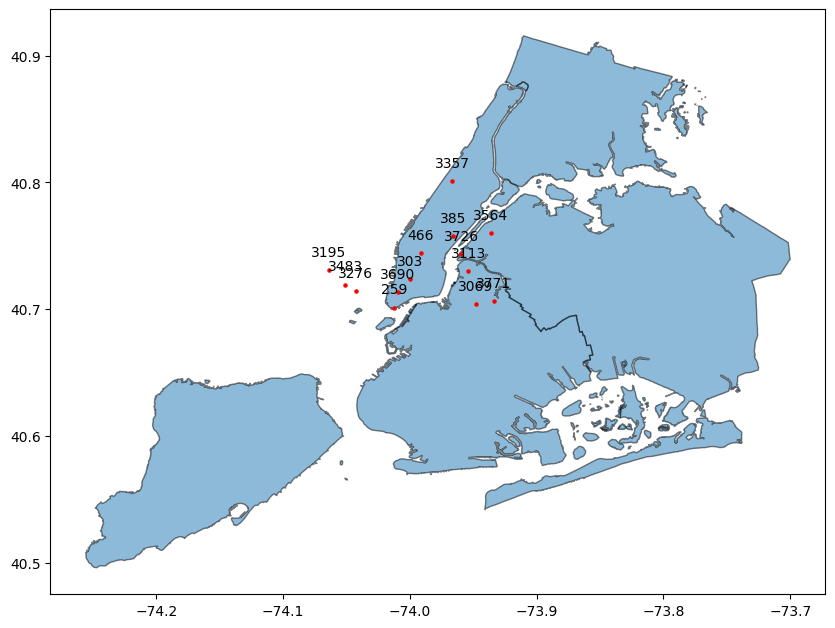

In [ ]:
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['lon'], stations['lat']))

# Plot the NYC map
manhattan.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Plot your data points on top of the map and add labels
ax = gdf.plot(marker='o', color='red', markersize=5, ax=plt.gca())

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.index):
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Show the plot
plt.show()

We see we may have stations outside NYC, in NJ. Let's confirm by printing the number of regions in the dataset:

In [ ]:
stations.region_id.value_counts()

region_id
71    11
70     3
Name: count, dtype: int64

In [ ]:
# Get only station in NYC, not the 3 stations in New Jersey:
df_nyc = df.query("region_id == '71'")

station_variables = ['station_id', 'station_name', 'lat', 'lon', 'region_id', 'capacity']
stations = df_nyc.groupby(station_variables).size().reset_index(name='count').copy()
stations = stations.sort_values(by='count', ascending=False).set_index('station_id')
stations

,station_name,lat,lon,region_id,capacity,count
station_id,,,,,,
466,W 25 St & 6 Ave,40.743954,-73.991449,71,35,81924
303,Mercer St & Spring St,40.723627,-73.999496,71,67,67207
259,South St & Whitehall St,40.701221,-74.012342,71,39,48657
385,E 55 St & 2 Ave,40.757973,-73.966033,71,29,45922
3113,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,71,27,42447
3690,Park Pl & Church St,40.713342,-74.009355,71,36,40255
3357,W 106 St & Amsterdam Ave,40.800836,-73.966449,71,35,38183
3726,Center Blvd & 51 Ave,40.743366,-73.959607,71,20,29315
3771,McKibbin St & Bogart St,40.706237,-73.933871,71,30,24092


In [ ]:
print(f'Number of rows: {df_nyc.size:,} million')

Number of rows: 8,095,896 million


## BIKE/DOCK AVAILABILITY (PER STATION)

Let's analyze the two variables of interest `num_docks_available`and `num_bikes_available` reported in this doc:

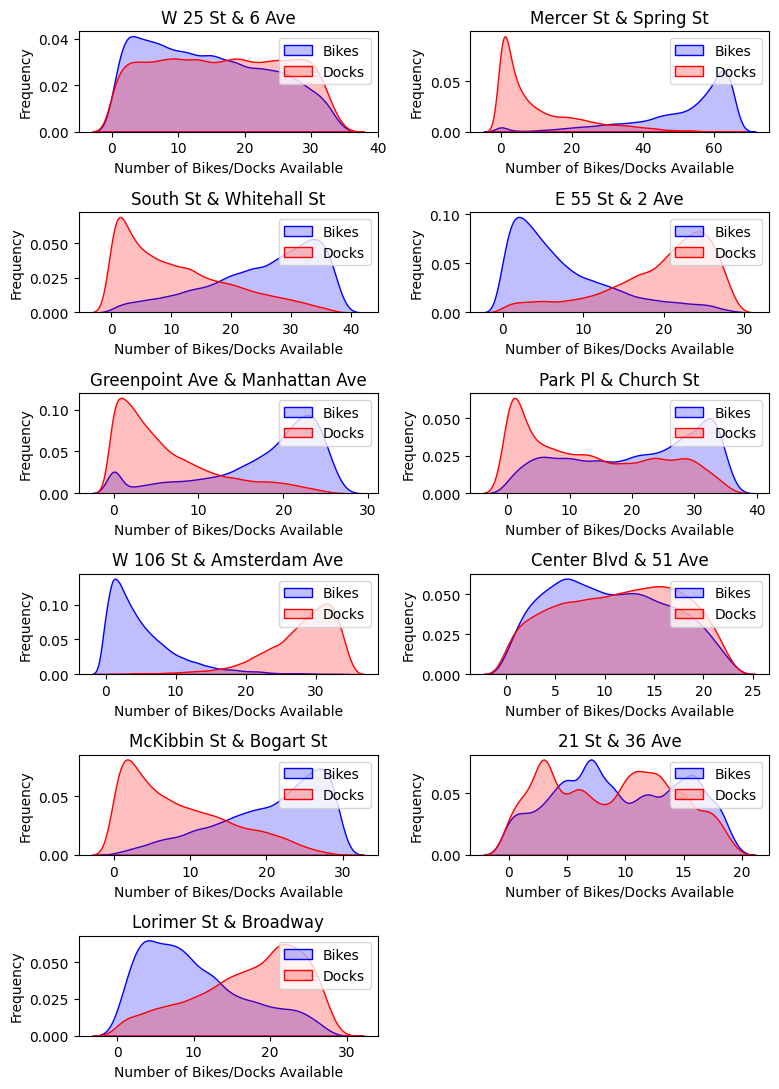

In [ ]:
# Create a figure with multiple subplots in a row
num_rows = len(stations.station_name)
num_cols = 2  # Two columns for side-by-side plots
fig, axs = plt.subplots(math.ceil(num_rows/2), num_cols, figsize=(8, 1 * num_rows))

# Loop through each station_name and create a histogram
for i, station_name in enumerate(stations.station_name):
    row = i // num_cols  # Calculate the row index
    col = i % num_cols   # Calculate the column index

    station_data = df_nyc[df_nyc['station_name'] == station_name][['num_bikes_available', 'num_docks_available']]

    # Create a distribution for the station
    sns.kdeplot(station_data.num_bikes_available, ax=axs[row, col], shade=True, color='blue', label='Bikes')
    sns.kdeplot(station_data.num_docks_available, ax=axs[row, col], shade=True, color='red', label='Docks')

    # Add titles and Legend
    axs[row, col].set_title(f'{station_name}')
    axs[row, col].set_xlabel('Number of Bikes/Docks Available')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].legend()

# Adjust the layout and spacing
plt.tight_layout()
fig.delaxes(axs[-1][-1])
# Display the plot
plt.show()

As we can see, the `num_docks_available`and `num_bikes_available` distributions are a mirror as if the bike gets rented, there will be the same amount of docks freed. But why do we see a slight difference between both distributions? Because there are also bikes and docks marked as `disabled`. Additionally, we can see how the distribution for the bikes available does vary from station to station, so we expect `station` to be a fundamental feature of our prediction.

> Let's remember our **main objective**: predict the **bike/dock availability**.

With this in mind, we need to find a variable that represents the availability of both bikes and docks in a station. The next image shows a representation of what we will call `true bike capacity` which will help us model **both our variables in one**:

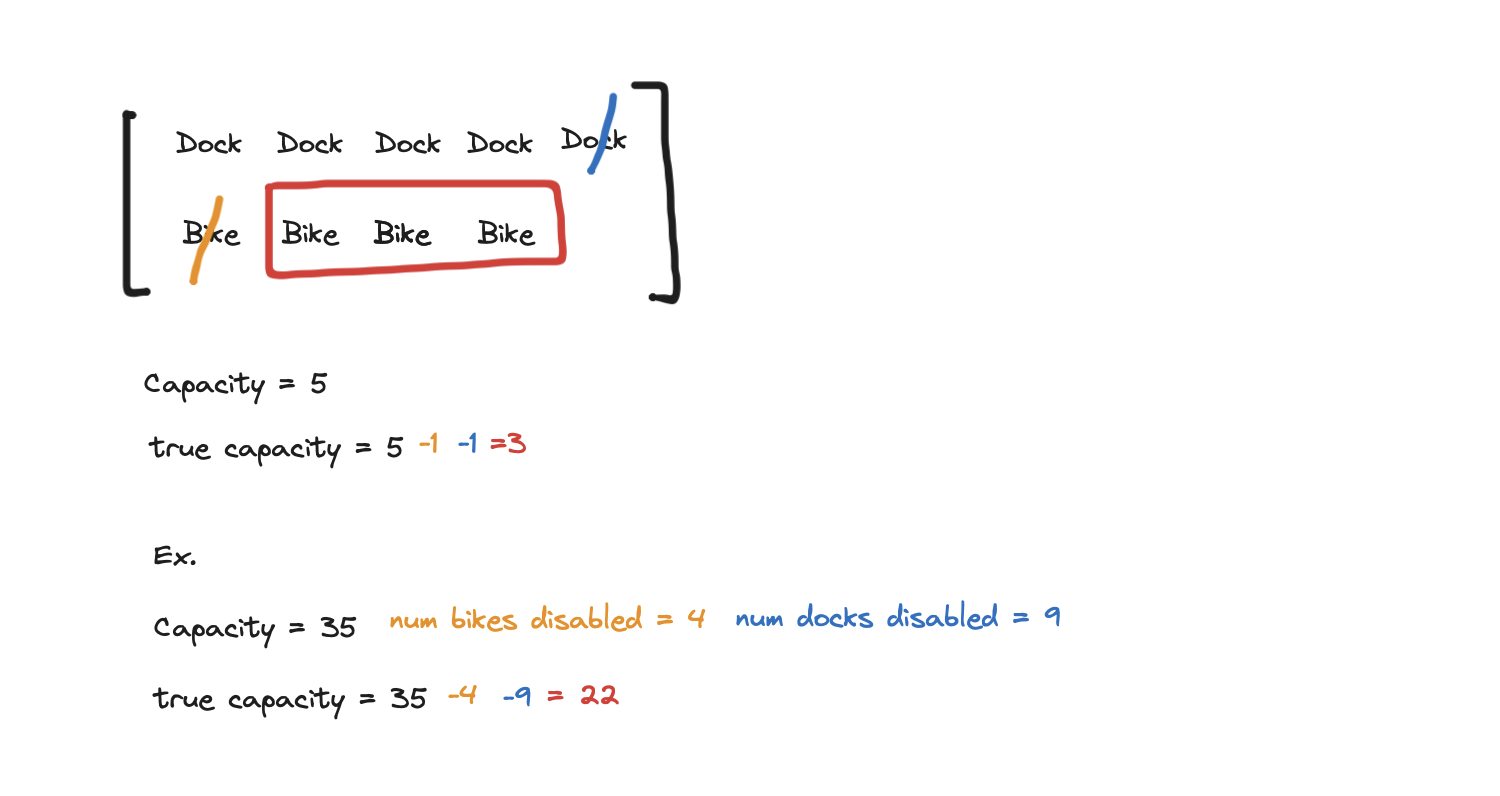

We can see how the `true bike capacity` is just the `bike capacity`, minus the docks and bikes disabled.

In [ ]:
# Row used in example:
df_nyc.filter(items = [6225749], axis=0)[['capacity', 'num_bikes_disabled', 'num_docks_disabled']]

,capacity,num_bikes_disabled,num_docks_disabled
6225749,35,4,9


## TRUE BIKE CAPACITY

 Let's start preparing that new variable:

In [ ]:
df_prep = df_nyc.copy()
df_prep['true_bike_capacity'] = df_prep['capacity']-(df_prep['num_bikes_disabled']+df_prep['num_docks_disabled'])

Now, the **bikes available and the docks available** will be equal to the `true_capacity`. So, we can calculate `percentage_bikes_available`and `percentage_docks_available`, and they should sum up to 1 (we can use this to validate our data):

In [ ]:
df_prep['percentage_bikes_available'] = df_prep['num_bikes_available']*1.0/df_prep['true_bike_capacity'] 
df_prep['percentage_docks_available'] = df_prep['num_docks_available']*1.0/df_prep['true_bike_capacity']
df_prep['sum_percentage_validation'] = df_prep['percentage_bikes_available'] + df_prep['percentage_docks_available'] # Needs to be 1

In [ ]:
print(f"Percentage of validated rows:{round(len(df_prep[df_prep['sum_percentage_validation']== 1])/len(df_prep),2)*100}%.")
print(f"Percentage of rows that need additional review:{round(len(df_prep[df_prep['sum_percentage_validation']!= 1])/len(df_prep),2)*100}%.")

Percentage of validated rows:99.0%.
Percentage of rows that need additional review:1.0%.


We have rows where the percentage of available bikes plus available docks isn't one. That can't happen, so let's explore these invalid rows:

In [ ]:
df_prep[df_prep['sum_percentage_validation']!= 1]

,station_id,num_bikes_available,num_ebikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,station_status_last_reported,...,lon,region_id,capacity,has_kiosk,station_information_last_updated,missing_station_information,true_bike_capacity,percentage_bikes_available,percentage_docks_available,sum_percentage_validation
64,385,10,0,4,1,0,1,1,1,2021-11-18 16:19:40-05:00,...,-73.966033,71,29,True,2019-08-01 16:47:30-04:00,False,25,0.4,0.04,0.44
851,3113,0,0,25,0,2,1,1,1,2021-11-26 05:07:35-05:00,...,-73.953940,71,27,True,2019-08-01 16:47:30-04:00,False,0,NaN,NaN,NaN
884,3113,0,0,25,0,2,1,1,1,2021-11-23 15:14:56-05:00,...,-73.953940,71,27,True,2019-08-01 16:47:30-04:00,False,0,NaN,NaN,NaN
1537,3113,0,0,25,0,2,1,1,1,2021-11-23 01:36:19-05:00,...,-73.953940,71,27,True,2019-08-01 16:47:30-04:00,False,0,NaN,NaN,NaN
2316,3726,8,1,1,14,0,1,1,1,2021-06-23 22:39:19-04:00,...,-73.959607,71,20,True,2019-08-01 16:47:30-04:00,False,19,0.421053,0.736842,1.157895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6220523,3726,15,0,2,6,0,1,1,1,2021-09-22 07:08:57-04:00,...,-73.959607,71,20,True,2019-08-01 16:47:30-04:00,False,18,0.833333,0.333333,1.166667
6220524,3726,0,0,3,20,0,1,1,1,2021-06-05 20:12:41-04:00,...,-73.959607,71,20,True,2019-08-01 16:47:30-04:00,False,17,0.0,1.176471,1.176471
6220919,3564,9,1,1,8,0,1,1,1,2021-08-23 05:11:50-04:00,...,-73.936273,71,19,True,2019-08-01 16:47:30-04:00,False,18,0.5,0.444444,0.944444
6221058,3726,4,0,0,19,0,1,1,1,2021-10-31 15:58:01-04:00,...,-73.959607,71,20,True,2019-08-01 16:47:30-04:00,False,20,0.2,0.95,1.15


We said the **bikes available and the docks available** will be equal to the `true_capacity`, so let's explore the edge cases where this is violated (when the bikes and docks available is bigger than the true capacity):

In [ ]:
df_prep[df_prep['true_bike_capacity']<df_prep['num_bikes_available']].station_id.unique()

array(['3726'], dtype=object)

In [ ]:
df_prep[df_prep['true_bike_capacity']<df_prep['num_docks_available']].station_id.unique()

array(['3726'], dtype=object)

It only happens for the station 3726, what is happening?

In [ ]:
df_prep[df_prep.station_id=='3726'][['station_id', 'num_bikes_available', 'num_docks_available', 'true_bike_capacity', 'capacity']].sort_values(by=['num_bikes_available'], ascending=False)


,station_id,num_bikes_available,num_docks_available,true_bike_capacity,capacity
2495824,3726,23,0,20,20
319216,3726,23,0,20,20
3013576,3726,23,0,20,20
1938960,3726,23,0,20,20
876099,3726,23,0,20,20
...,...,...,...,...,...
1783768,3726,0,23,20,20
3954836,3726,0,11,8,20
2635983,3726,0,23,20,20
2401843,3726,0,23,20,20


Our hypothesis is that we have an error in the data, we see that the capacity for station 3726 (Center Blvd & 51 Ave) may be incorrect (it doesn't make sense to have 23 bikes available on a station with a maximum 20 bikes).

In [ ]:
df_prep[df_prep.station_id=='3726'][['station_id', 'num_bikes_available', 'num_docks_available', 'true_bike_capacity', 'capacity']].sort_values(by=['num_docks_available'], ascending=False)

,station_id,num_bikes_available,num_docks_available,true_bike_capacity,capacity
1055814,3726,0,23,20,20
1975114,3726,0,23,20,20
872627,3726,0,23,20,20
618755,3726,0,23,20,20
672092,3726,0,23,20,20
...,...,...,...,...,...
5968888,3726,21,0,18,20
2289971,3726,23,0,20,20
1176749,3726,22,0,19,20
394583,3726,21,0,18,20


The same for docks! For this reason, we'll fix this by correcting the `capacity`:

In [ ]:
df_prep.loc[df_prep["station_id"] == "3726", "capacity"] = 23
df_prep['true_bike_capacity'] = df_prep['capacity']-(df_prep['num_bikes_disabled']+df_prep['num_docks_disabled'])
df_prep['percentage_bikes_available'] = df_prep['num_bikes_available']*1.0/df_prep['true_bike_capacity'] 
df_prep['percentage_docks_available'] = df_prep['num_docks_available']*1.0/df_prep['true_bike_capacity']
df_prep['sum_percentage_validation'] = df_prep['percentage_bikes_available'] + df_prep['percentage_docks_available'] # Needs to be 1

In [ ]:
print(f"Percentage of validated rows:{round(len(df_prep[df_prep['sum_percentage_validation']== 1])/len(df_prep),2)}%.")
print(f"Percentage of rows that need additional review:{round(len(df_prep[df_prep['sum_percentage_validation']!= 1])/len(df_prep),2)}%.")

Percentage of validated rows:0.99%.
Percentage of rows that need additional review:0.01%.


Ok, now we only have .01% of incorrect data. Let's check the 2 possible things that can happen if the sum isn't 1: sum is greater than 1 or sum is less than 1.

In [ ]:
df_prep[df_prep['sum_percentage_validation'] > 1]

,station_id,num_bikes_available,num_ebikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,station_status_last_reported,...,lon,region_id,capacity,has_kiosk,station_information_last_updated,missing_station_information,true_bike_capacity,percentage_bikes_available,percentage_docks_available,sum_percentage_validation


In [ ]:
df_prep[df_prep['sum_percentage_validation'] < 1][['station_id','num_bikes_available', 'num_docks_available', 'true_bike_capacity']]

,station_id,num_bikes_available,num_docks_available,true_bike_capacity
64,385,10,1,25
2560,303,42,6,64
2831,303,3,1,66
6486,3690,30,5,36
8281,3357,5,19,34
...,...,...,...,...
6212995,3690,5,1,35
6214544,303,49,2,67
6217102,3357,7,17,34
6220919,3564,9,8,18


We think these rows may be mistaken as the numbers don't add up. Let's see an example:

In [ ]:
df_prep[df_prep['sum_percentage_validation'] < 1][['station_id','num_bikes_available', 'num_docks_available', 'true_bike_capacity']].head(1)

,station_id,num_bikes_available,num_docks_available,true_bike_capacity
64,385,10,1,25


For this station, we have a true capacity of 25 (the real 29 capacity minus 1 dock unavailable, minus 3 bikes unavailable). So, we should have our bikes and docks summing up to that 25 capacity. But we have 10 bikes available and 1 dock available (11<25)! So, we cannot have docks either occupied or available! So, this is a capture error. Given we don't have additional information to fix these rows, we will remove them from our data (one thing that could be done if we were the owners of the data could be to move forward to investigate the root cause of the error).

In [ ]:
df_prep = df_prep[df_prep['sum_percentage_validation'] == 1]

In [ ]:
df_prep.head()

,station_id,num_bikes_available,num_ebikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,station_status_last_reported,...,lon,region_id,capacity,has_kiosk,station_information_last_updated,missing_station_information,true_bike_capacity,percentage_bikes_available,percentage_docks_available,sum_percentage_validation
14,385,3,0,2,24,0,1,1,1,2021-08-25 12:09:38-04:00,...,-73.966033,71,29,True,2019-08-01 16:47:30-04:00,False,27,0.111111,0.888889,1.0
16,385,7,1,0,22,0,1,1,1,2021-11-30 06:45:05-05:00,...,-73.966033,71,29,True,2019-08-01 16:47:30-04:00,False,29,0.241379,0.758621,1.0
18,385,1,0,1,27,0,1,1,1,2021-11-20 17:54:08-05:00,...,-73.966033,71,29,True,2019-08-01 16:47:30-04:00,False,28,0.035714,0.964286,1.0
21,385,0,0,4,25,0,1,1,1,2021-10-07 22:41:46-04:00,...,-73.966033,71,29,True,2019-08-01 16:47:30-04:00,False,25,0.0,1.0,1.0
42,385,5,0,1,23,0,1,1,1,2021-03-23 21:41:03-04:00,...,-73.966033,71,29,True,2019-08-01 16:47:30-04:00,False,28,0.178571,0.821429,1.0


## PERCENTAGE DOCKS/BIKES AVAILABLE

Let's plot the distribution of our new variables (we want to prove they're complementary so that we can now model both things bike/dock availability with one variable). First we we'll plot it in general and then by station.

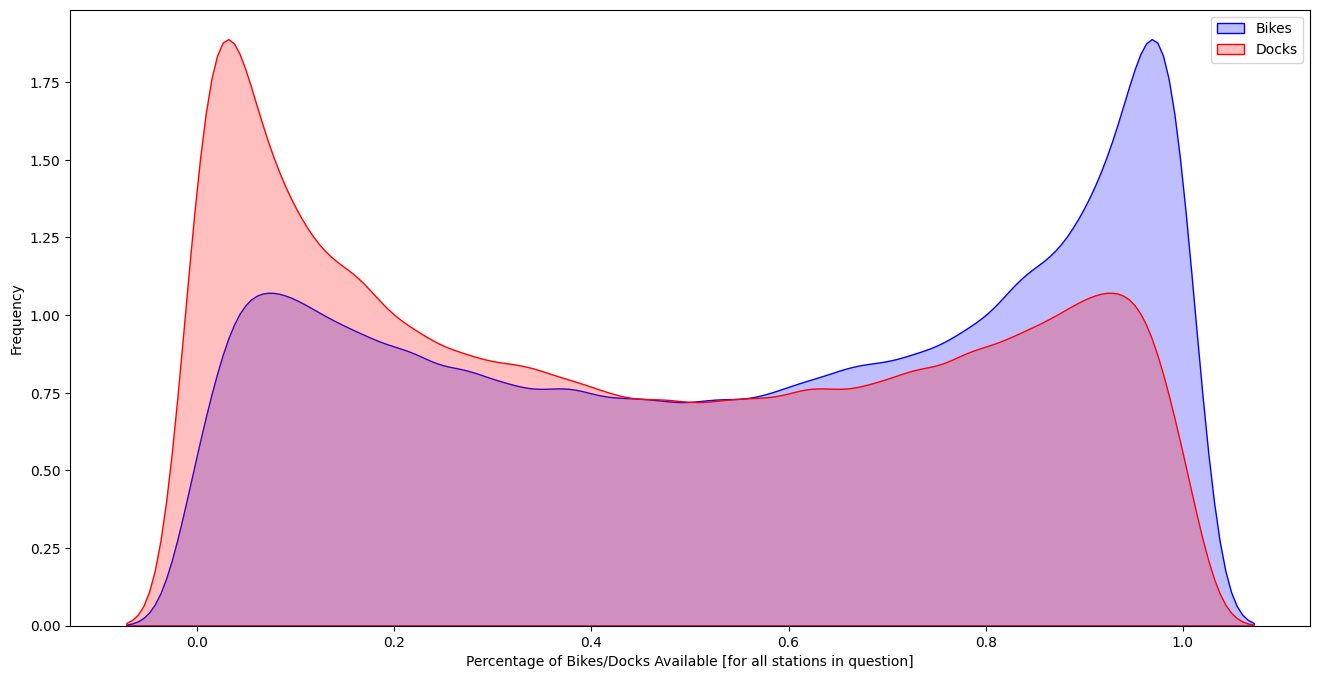

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

sns.kdeplot(df_prep.percentage_bikes_available, shade=True, color='blue', label='Bikes', ax=axs)
sns.kdeplot(df_prep.percentage_docks_available, shade=True, color='red', label='Docks', ax=axs)

axs.set_xlabel('Percentage of Bikes/Docks Available [for all stations in question]')
axs.set_ylabel('Frequency')
axs.legend()

plt.show()

We can see how both distributions are indeed complementary! To interpret, let's take the "Bike Availability": 

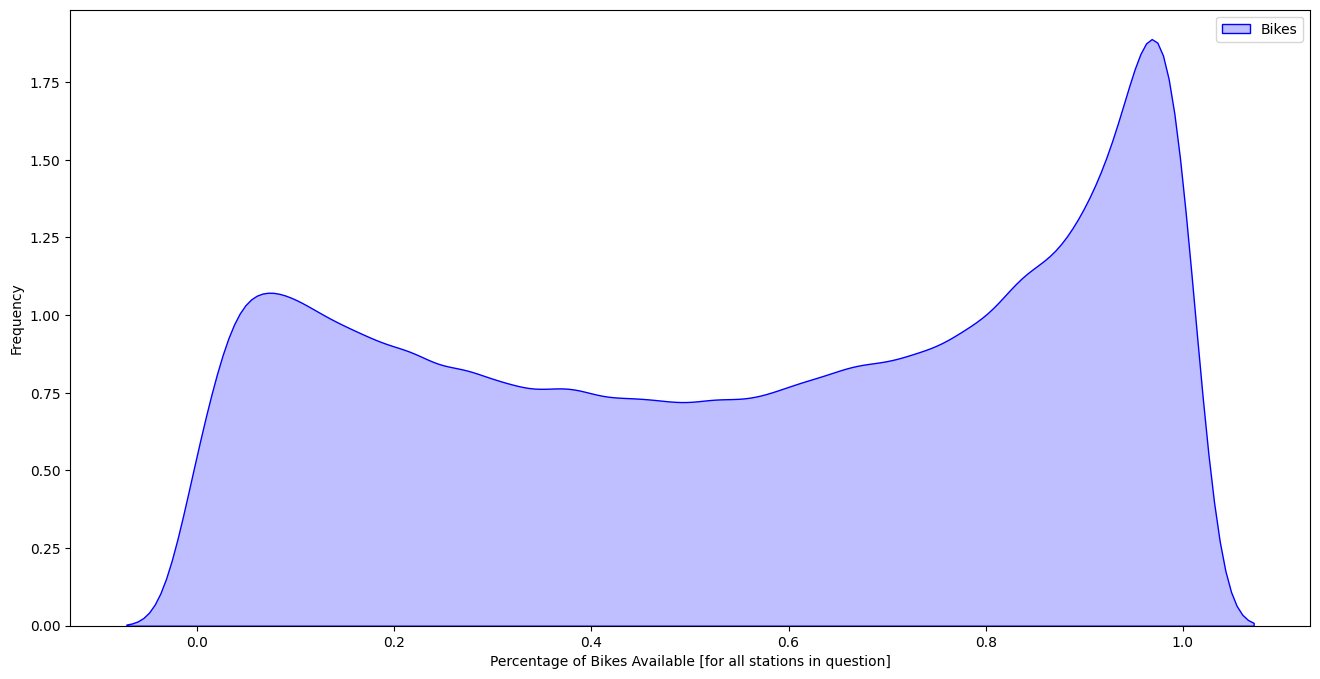

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

sns.kdeplot(df_prep.percentage_bikes_available, shade=True, color='blue', label='Bikes', ax=axs)

axs.set_xlabel('Percentage of Bikes Available [for all stations in question]')
axs.set_ylabel('Frequency')
axs.legend()

plt.show()

We can see how it's a multimodal distribution (2 "famous" percentages).

In [ ]:
value_counts = df_prep['percentage_docks_available'].value_counts()
top_two_values = value_counts.head(2)

print("Two most frequent values:")
print(top_two_values)

Two most frequent values:
percentage_docks_available
0.0    20911
1.0     8631
Name: count, dtype: Int64


We see that these 2 peeks are on 0 and 1, so, in general, the most frequent thing to happen is two have a full or an empty station, and the probability of having other percentages of docks available seems very uniform (this is why we need additional variables, as station or time). Let's see by station:

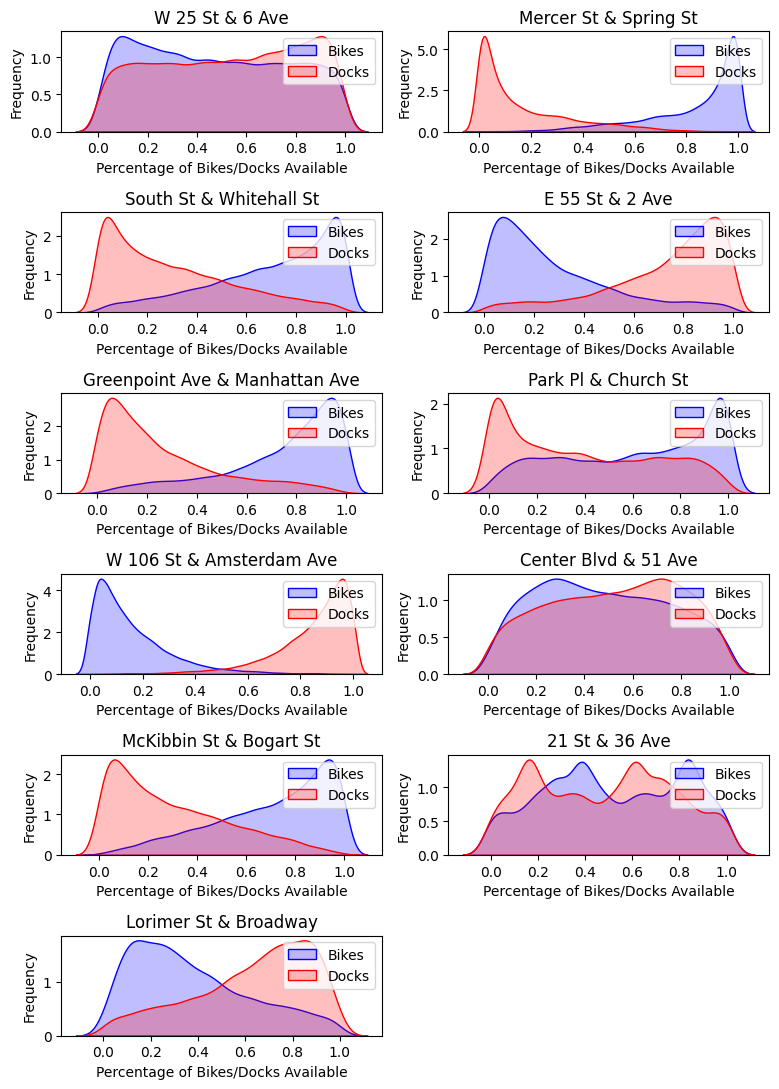

In [ ]:
# Create a figure with multiple subplots in a row
num_rows = len(stations.station_name)
num_cols = 2  # Two columns for side-by-side plots
fig, axs = plt.subplots(math.ceil(num_rows/2), num_cols, figsize=(8, 1 * num_rows))

# Loop through each station_name and create a histogram
for i, station_name in enumerate(stations.station_name):
    row = i // num_cols  # Calculate the row index
    col = i % num_cols   # Calculate the column index

    station_data = df_prep[df_prep['station_name'] == station_name][['percentage_bikes_available','percentage_docks_available']]

    # Create a distribution for the station
    sns.kdeplot(station_data.percentage_bikes_available, ax=axs[row, col], shade=True, color='blue', label='Bikes')
    sns.kdeplot(station_data.percentage_docks_available, ax=axs[row, col], shade=True, color='red', label='Docks')

    # Add titles and Legend
    axs[row, col].set_title(f'{station_name}')
    axs[row, col].set_xlabel('Percentage of Bikes/Docks Available')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].legend()

# Adjust the layout and spacing
plt.tight_layout()
fig.delaxes(axs[-1][-1])
# Display the plot
plt.show()

We can observe how the bike/dock availability for each station does vary. For example, let's take McKibbin, we can see the most common status is having high bike availability, and on W 106 St & Amsterdam Ave, it's the other way around.

## CONCLUSION

We have cleaned and prepared the **status data** of 11 bike stations in the NYC bike-share system (citibike) over a period of 1 year. We also created a variable `percentage_bike_availability` that we can use to obtain both bike/dock availability over time. Additionally, we saw how the feature `station` will indeed be a variable that impacts our predictions. 

Following, you will find an illustration of our new variable to predict:
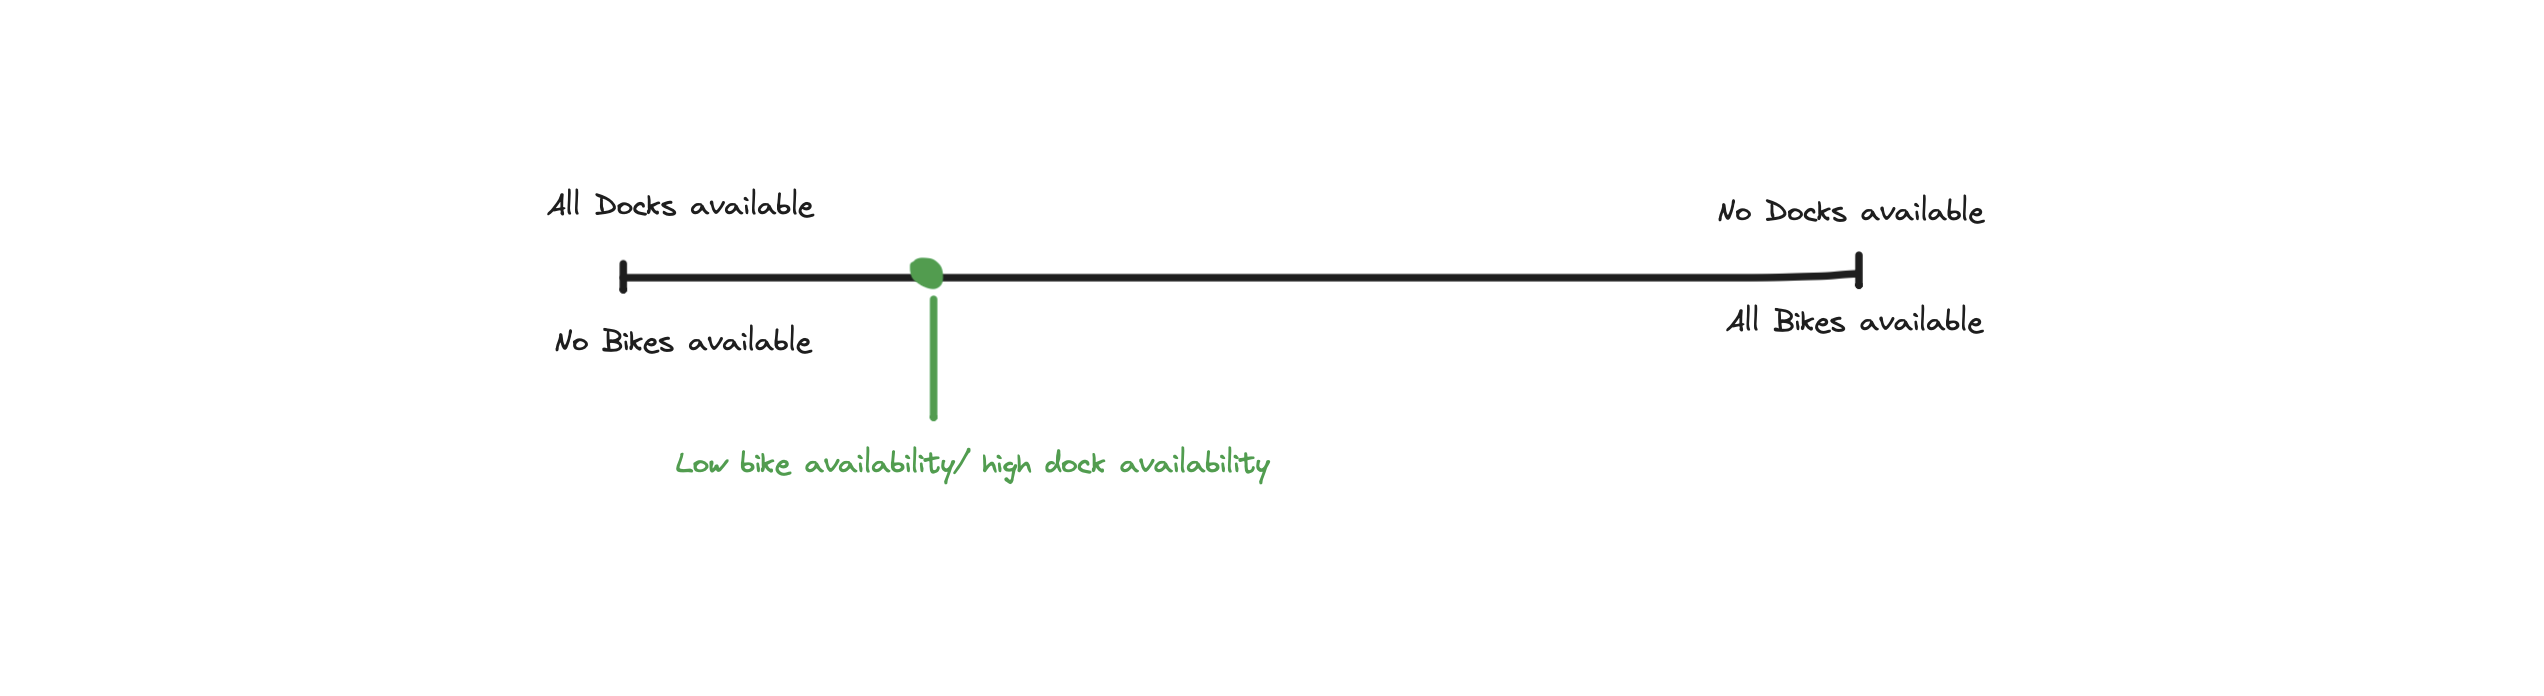

In next notebooks, we will create additional features to not only predict using the station, but also the variable of time.

## EXPORT DATA

In [ ]:
# Leave only important features:
df_ml = df_prep[['station_id', 'station_status_last_reported', 'lat', 'lon', 'true_bike_capacity', 'capacity', 'percentage_bikes_available']].copy()
df_ml.head()

,station_id,station_status_last_reported,lat,lon,true_bike_capacity,capacity,percentage_bikes_available
14,385,2021-08-25 12:09:38-04:00,40.757973,-73.966033,27,29,0.111111
16,385,2021-11-30 06:45:05-05:00,40.757973,-73.966033,29,29,0.241379
18,385,2021-11-20 17:54:08-05:00,40.757973,-73.966033,28,29,0.035714
21,385,2021-10-07 22:41:46-04:00,40.757973,-73.966033,25,29,0.0
42,385,2021-03-23 21:41:03-04:00,40.757973,-73.966033,28,29,0.178571


In [ ]:
stations = df_prep.groupby(station_variables).size().reset_index(name='count')
stations

,station_id,station_name,lat,lon,region_id,capacity,count
0,259,South St & Whitehall St,40.701221,-74.012342,71,39,48656
1,303,Mercer St & Spring St,40.723627,-73.999496,71,67,65342
2,3069,Lorimer St & Broadway,40.704118,-73.948186,71,29,11213
3,3113,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,71,27,40306
4,3357,W 106 St & Amsterdam Ave,40.800836,-73.966449,71,35,37573
5,3564,21 St & 36 Ave,40.760185,-73.936273,71,19,20264
6,3690,Park Pl & Church St,40.713342,-74.009355,71,36,39572
7,3726,Center Blvd & 51 Ave,40.743366,-73.959607,71,23,29310
8,3771,McKibbin St & Bogart St,40.706237,-73.933871,71,30,24092
9,385,E 55 St & 2 Ave,40.757973,-73.966033,71,29,45805


In [ ]:
df_ml.to_pickle("../data/data_ml.pkl")
stations.to_pickle("../data/stations.pkl")